# Extracting contour lines

**What does this notebook do?** 

This notebook demonstrates how to use the `contour_extract` function to extract multiple contours from a two-dimensional array, or individual contours from every array along a specified dimension in a multi-dimensional array. Contours can be extracted either from digital elevation data (DEMs), or from any other data such as extracting waterline boundaries from Landsat-derived Normalized Difference Water Index (NDWI) data across time.

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea` 

This notebook uses an external function called `contour_extract`. This function is available in the `10_Scripts` folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/10_Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** November 2018

**Author:** Robbi Bishop-Taylor

## Load modules

In [2]:
# Import modules
import os
import sys
import datacube 
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../10_Scripts')
import SpatialTools

# Set up datacube instance
dc = datacube.Datacube(app='Contour extraction')


## Load in elevation data
Here we use `dc.load` to import Shuttle Radar Topography Mission (SRTM) Digital Elevation Model (DEM) data for Canberra. This returns a hydrologically enforced digital elevation model (DEM-H):

In [3]:
# Elevation query
elevation_query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25)
}

# Load in DEM data
elevation_data = dc.load(product='srtm_dem1sv1_0', **elevation_query)
elevation_data

<xarray.Dataset>
Dimensions:  (time: 1, x: 492, y: 500)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-15T14:58:44
  * y        (y) float64 -3.953e+06 -3.953e+06 ... -3.966e+06 -3.966e+06
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 ... 1.555e+06 1.555e+06
Data variables:
    dem      (time, y, x) float32 653.0692 652.3962 651.54095 ... 583.0 582.0
    dem_s    (time, y, x) float32 651.44354 651.31757 ... 583.69037 582.87164
    dem_h    (time, y, x) float32 651.2039 651.0723 ... 583.68713 582.76434
Attributes:
    crs:      EPSG:3577

Create a terrain-coloured colour map and plot the DEM-H data:

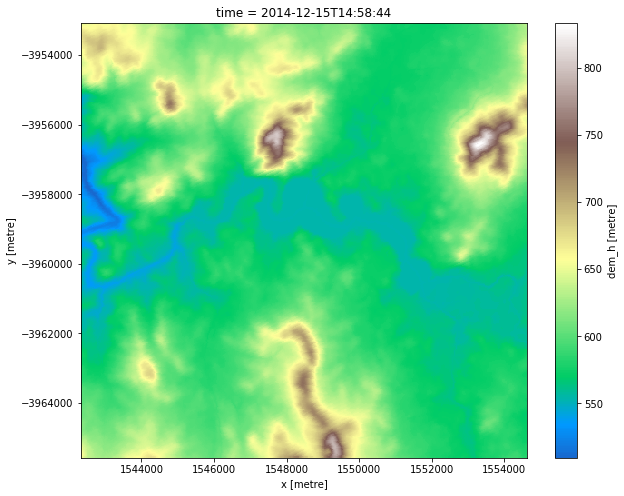

In [4]:
# Create a custom colourmap for the DEM 
colors_terrain = plt.cm.terrain(np.linspace(0.08, 1, 200))
cmap_terrain = mpl.colors.LinearSegmentedColormap.from_list('terrain', colors_terrain)

# Plot the elevation; `squeeze` removes the uncessessary time dimension
plt.figure(figsize=(10, 8))
elevation_data.dem_h.squeeze('time').plot(cmap=cmap_terrain)


## Contour extraction in 'single array, multiple z-values' mode
The `SpatialTools.contour_extract` function uses `skimage.measure.find_contours` to extract contour lines from an array. This can be an elevation dataset like the data imported above, or any other two-dimensional or multi-dimensional array. We can extract contours from the elevation array imported above by providing a single z-value/elevation or a list of `z_values`/elevations. We also need to provide a `crs` and an `affine` object, both of which can be obtained from the xarray DataArray.

### Extracting a single contour
Here, we extract a single 600 m elevation contour:


In [38]:
# Remove the time dimension to return a two-dimensional array. This is not strictly necessary as the
# function will drop the time dimension automatically if it has a length of 1, but it is good practice:
elevation_2d = elevation_data.dem_h.squeeze('time')

# Extract contours
contour_gdf = SpatialTools.contour_extract(z_values=600,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours.shp')

# Print output
contour_gdf

Operating in single array, multiple z-values mode
    Extracting contour 600
Exporting contour shapefile to extracted_contours.shp


,z_value,geometry
0,600.0,"(LINESTRING (1545252.210436996 -3953087.5, 154..."


This writes the shapefile to file, and returns a Geopandas geodataframe containing a single contour line feature with the z-value (i.e. elevation) given in a shapefile field named `z_value`. We can plot this:

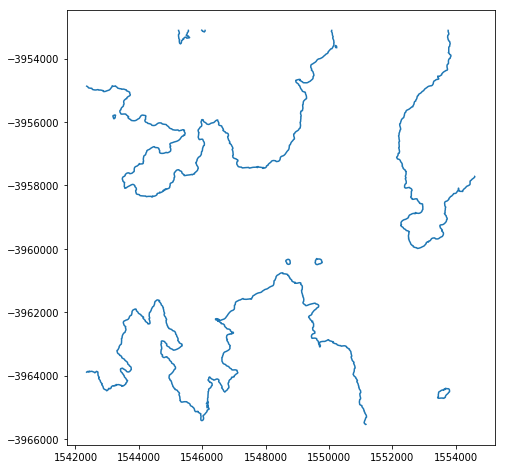

In [39]:
# Plot extracted contour:
contour_gdf.plot(figsize=(10, 8))

### Extracting multiple contours 
We can easily import multiple contours from a single array by supplying a list of z-values to extract. The function will then extract a contour for each value in `z_values`, skipping any contour elevation that is not found in the array (e.g. 850 m below):

Operating in single array, multiple z-values mode
    Extracting contour 550
    Extracting contour 600
    Extracting contour 650
    Extracting contour 700
    Extracting contour 750
    Extracting contour 800
    Extracting contour 850
    No data for contour 850; skipping
Exporting contour shapefile to extracted_contours.shp


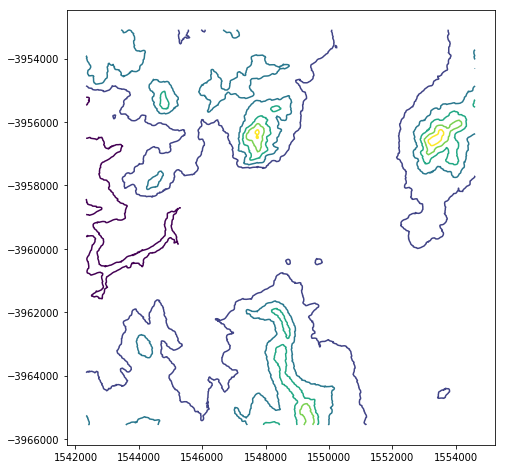

In [40]:
# List of elevations to extract
elev_list = [550, 600, 650, 700, 750, 800, 850]

# Extract contours
contour_gdf = SpatialTools.contour_extract(z_values=elev_list,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours.shp')

# Plot extracted contours, colouring contours by their z-value/elevation:
contour_gdf.plot(column='z_value', figsize=(10, 8))

Any number of contours can be extracted; below we extract one contour for every 10 m in elevation. For this kind of extraction, it can be useful to use the `verbose=False` parameter to prevent the large number of contour extractions being printed to the screen:

Operating in single array, multiple z-values mode
Exporting contour shapefile to extracted_contours.shp


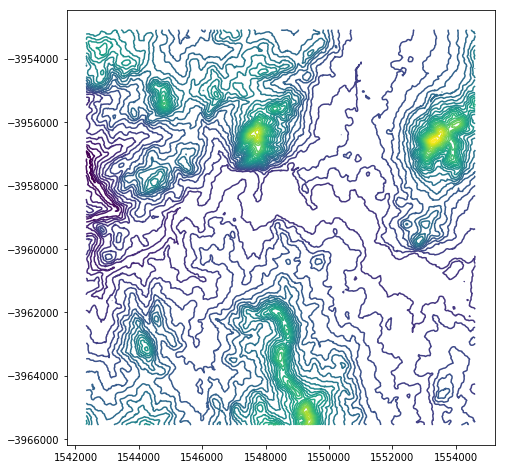

In [41]:
# List of elevations to extract
elev_list = list(range(510, 840, 10))

#Extract contours and export to a shapefile
contour_gdf = SpatialTools.contour_extract(z_values=elev_list,
                                           ds_array=elevation_2d,
                                           ds_crs=elevation_data.geobox.crs,
                                           ds_affine=elevation_data.geobox.affine,
                                           output_shp='extracted_contours.shp',
                                           verbose=False)

# Plot extracted contours, colouring contours by their z-value/elevation:
contour_gdf.plot(column='z_value', figsize=(10, 8))

We can plot the contours over the top of the original elevation array to verify they are in the correct locations:

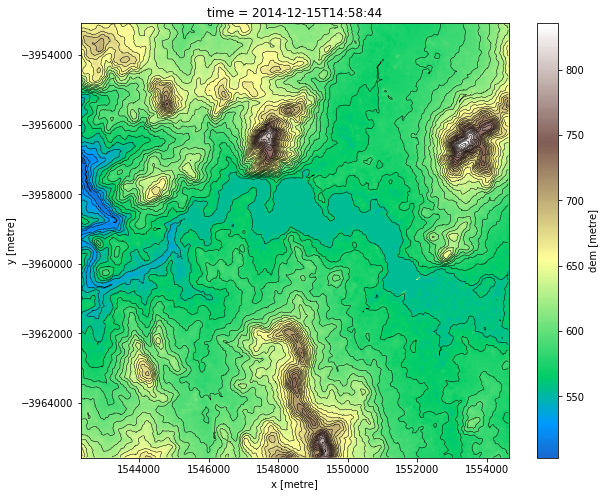

In [42]:
# Plot contours over the top of elevation array
fig, ax = plt.subplots(figsize=(10, 8))
elevation_data.dem.isel(time=0).plot(ax=ax, cmap=cmap_terrain)
contour_gdf.plot(ax=ax, linewidth=0.5, color='black')

### Custom shapefile attributes
By default, the shapefile includes a single `z_value` attribute field with one feature per input value in `z_values`. We can instead pass custom attributes to the output
shapefile using the `attribute_data` and `attribute_dtypes` parameters. For example, we might want a custom column called `elev_cm` with heights in cm instead of m, and a `location` column giving the location (Canberra). 

We can achieve this by passing in a dict with field names as keys, and a list of values of the same length as `z_values`. When passing in custom attributes, we also need to manually set the dtypes for the output fields using an `attribute_dtypes` dictionary. The dict should have the same keys/field names as declared in `attribute_data`, and values which include 'int', 'str', 'datetime, and 'float:X.Y', where X is the minimum number of characters before the decimal place, and Y is the number of characters after the decimal place:

In [43]:
# Elevation values to extract
elev_values = [550, 600, 650, 700, 750, 800, 850]

# Set up dicts with the attribute field name as the dict key, and lists of values of the same
# length as `z_values`:
custom_attrs = {'elev_cm': [55000, 60000, 65000, 70000, 75000, 80000, 85000],
                'location': ['Canberra', 'Canberra', 'Canberra', 'Canberra', 
                             'Canberra', 'Canberra', 'Canberra']}
custom_attrs_dtypes = {'elev_cm': 'int', 'location': 'str'}

# Extract contours with custom attribute fields:
contour_dict = SpatialTools.contour_extract(z_values=elev_values,
                                            ds_array=elevation_data.dem_h.squeeze('time'),
                                            ds_crs=elevation_data.geobox.crs,
                                            ds_affine=elevation_data.geobox.affine,
                                            output_shp='extracted_contours_attrs.shp',
                                            attribute_data=custom_attrs,
                                            attribute_dtypes=custom_attrs_dtypes)

# Import shapefile using geopandas to verify that the shapefile includes the new attributes:
contour_shp = gpd.read_file('extracted_contours_attrs.shp')
contour_shp

Operating in single array, multiple z-values mode
    Extracting contour 550
    Extracting contour 600
    Extracting contour 650
    Extracting contour 700
    Extracting contour 750
    Extracting contour 800
    Extracting contour 850
    No data for contour 850; skipping
Exporting contour shapefile to extracted_contours_attrs.shp


,elev_cm,location,geometry
0,55000,Canberra,"(LINESTRING (1542337.5 -3955470.764855981, 154..."
1,60000,Canberra,"(LINESTRING (1545252.210436996 -3953087.5, 154..."
2,65000,Canberra,"(LINESTRING (1543443.610875806 -3953087.5, 154..."
3,70000,Canberra,"(LINESTRING (1544862.5 -3955595.512401243, 154..."
4,75000,Canberra,"(LINESTRING (1553162.5 -3957020.618084073, 155..."
5,80000,Canberra,"(LINESTRING (1547737.5 -3956521.204322249, 154..."


## Contours from non-elevation datasets in in 'single z-value, multiple arrays' mode
As well as extracting multiple contours from a single two-dimensional array, `contour_extract` also allows you to extract a single z-value from every array along a specified dimension in a multi-dimensional array. This can be useful for comparing the changing topography of a landscape across time. The input multi-dimensional array does not need to be elevation data: contours can be extracted from any type of data. For example, we can use the function to extract the boundary between land and water. 

First, import some sample Landsat data and calculate a simple Normalized Difference Water Index (NDWI) on two cloud-free images. This index will have high values where a pixel is likely to be open water (e.g. NDWI > 0, or red colours below):

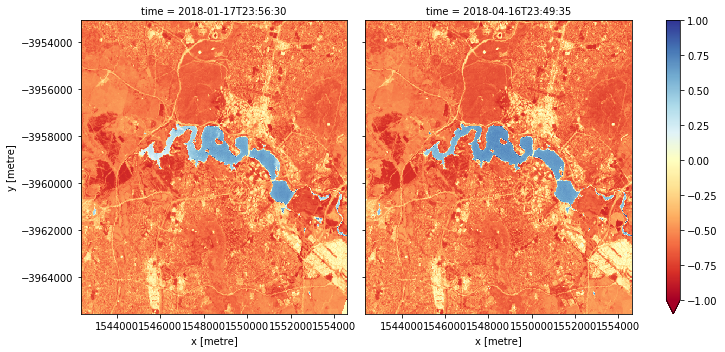

In [67]:
# Landsat query
landsat_query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'time': ('2018-01-10', '2018-04-20'),
        'measurements': ['red', 'green', 'blue', 'nir'],
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25)
}

# Load Landsat 8 data
landsat_data = dc.load(product='ls8_nbart_albers', 
                       group_by = 'solar_day', 
                       **landsat_query)

# Pull out two cloud-free observations
landsat_data = landsat_data.isel(time=[1, 12])

# Compute NDWI
landsat_ndwi = (landsat_data.green - landsat_data.nir) / \
               (landsat_data.green + landsat_data.nir)

# Plot
landsat_ndwi.plot(col='time', vmin=-1.0, vmax=1.0, cmap='RdYlBu', size=5)


We can now identify the land-water boundary by extracting the 0 NDWI contour for each array in the dataset along the `time` dimension. By plotting the resulting contour lines, we can then start to compare phenomenon like lake levels across time:

Operating in single z-value, multiple arrays mode
    Extracting contour 0
    Extracting contour 1
Exporting contour shapefile to extracted_contours_ndwi.shp


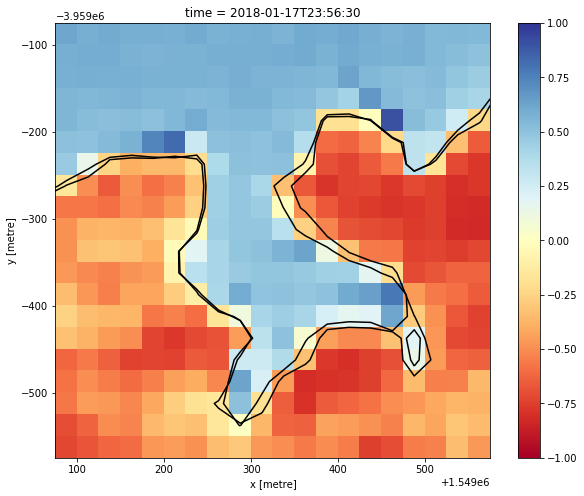

In [68]:
# Extract contours with custom attribute fields:
contour_gdf = SpatialTools.contour_extract(z_values=0,
                                           ds_array=landsat_ndwi,
                                           ds_crs=elevation_data.geobox.crs,
                                           ds_affine=elevation_data.geobox.affine,
                                           output_shp='extracted_contours_ndwi.shp')

# Plot contours over the top of array
fig, ax = plt.subplots(figsize=(10, 8))
landsat_ndwi.isel(time=0, x=slice(270, 290), y=slice(240, 260)).plot(ax=ax, vmin=-1.0, vmax=1.0, cmap='RdYlBu')
contour_gdf.plot(ax=ax, linewidth=1.5, color='black')

### Dropping small contours
Contours produced by `contour_extract` can include many small features. We can optionally choose to extract only contours larger than a certain number of vertices using the `min_vertices` parameter. This can be useful for focusing on large contours, and remove possible noise in a dataset. Here we set `min_vertices=20` to keep only contours with at least 20 vertices. Observe the small waterbody in the bottom-right of the image disappear:

Operating in single z-value, multiple arrays mode
    Extracting contour 0
    Extracting contour 1
Exporting contour shapefile to extracted_contours_ndwi.shp


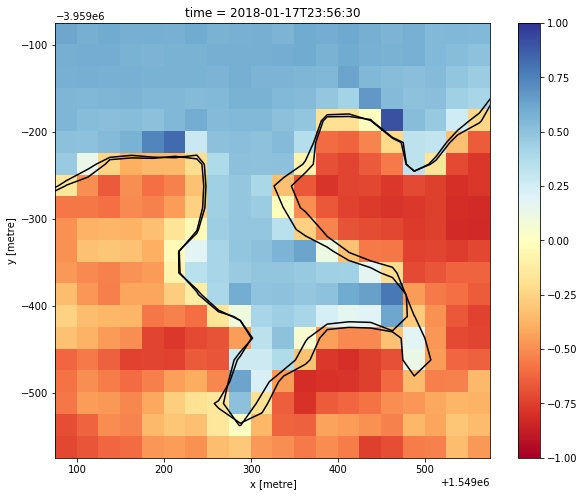

In [69]:
# Extract contours with custom attribute fields:
contour_dict = SpatialTools.contour_extract(z_values=0,
                                            ds_array=landsat_ndwi,
                                            ds_crs=elevation_data.geobox.crs,
                                            ds_affine=elevation_data.geobox.affine,
                                            output_shp='extracted_contours_ndwi.shp',
                                            min_vertices=20)

# Import shapefile using geopandas to verify that the shapefile includes the new attributes:
contour_shp = gpd.read_file('extracted_contours_ndwi.shp')
contour_shp

# Plot contours over the top of elevation array
fig, ax = plt.subplots(figsize=(10, 8))
landsat_ndwi.isel(time=0, x=slice(270, 290), y=slice(240, 260)).plot(ax=ax, vmin=-1.0, vmax=1.0, cmap='RdYlBu')
contour_shp.plot(ax=ax, linewidth=1.5, color='black')
